## Test pure-H2 convective shutdown

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",1)

In [4]:
F_earth = 1361.0
R_earth = 6.371e6
M_earth = 5.97e24

5.97e24

In [5]:
# Configuration options
instellation    = F_earth * (1/2.0)^2  # at 2 AU
mass            = M_earth
radius          = R_earth     
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 0.5        

s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_s        = 0.3
nlev_centre     = 35
p_top           = 1e-4      # bar 
mole_fractions  = Dict([("H2",  1.0)])
tmp_surf        = 1500.0
thermo          = true

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [6]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [7]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, 0.0, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo,
                        surface_material="blackbody",
                        albedo_s=albedo_s
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2      1.00e+00  


In [8]:
@printf("Instellation = %.2f W m-2 \n", atmos.instellation )

Instellation = 340.25 W m-2 


In [9]:
prs_arr = collect(range(start=3, stop=-1, step=-0.5))  # log(bar)
atm_arr = atmosphere.Atmos_t[]

nsamp = length(prs_arr)

@printf("Running model for %d samples... \n", nsamp)

setpt.isothermal!(atmos, 1000.0)

dx_max::Float64 = 200.0
modulate_mlt::Bool = false
linesearch::Bool = false

for (i,prs) in enumerate(prs_arr)
    @printf("sample %d/%d \n",i,nsamp)

    prs = 10.0^prs
    @printf("    pressure = %.1f bar \n", prs)

    atmos.p_boa = prs * 1.0e5 
    atmos.pl[end] = atmos.p_boa
    atmosphere.generate_pgrid!(atmos)

    if i > 1
        dx_max = 100.0
        modulate_mlt = false
        linesearch = true
    end 
    
    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=dx_max,
                                    linesearch=linesearch ,   
                                    save_frames=false, modplot=1,
                                    modprint=1, perturb_all=true,
                                    conv_atol=0.4, modulate_mlt=modulate_mlt 
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 9 samples... 
sample 1/9 
    pressure = 1000.0 bar 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  -5.95e+01  4.426e+04  4.431e+04  9.366e+02  1.200e+03  2.000e+02  C2-Nr 
[ INFO  ]        2  -4.88e+01  3.457e+04  3.462e+04  8.716e+02  1.400e+03  2.000e+02  C2-Nr 
[ INFO  ]        3  -3.77e+01  2.619e+04  2.624e+04  7.942e+02  1.600e+03  2.000e+02  C2-Nr 
[ INFO  ]        4  -2.26e+01  1.671e+04  1.676e+04  7.030e+02  1.800e+03  2.000e+02  C2-Nr 
[ INFO  ]        5  -7.07e+00  5.490e+03  5.536e+03  5.830e+02  1.793e+03  1.878e+02  C2-Nr 
[ INFO  ]        6  -2.65e+00  1.748e+03  1.793e+03  5.221e+02  1.809e+03  1.791e+02  C2-Nr 
[ INFO  ]        7  -8.51e-01  5.269e+02  5.712e+02  4.676e+02  1.972e+03  1.820e+02  C2-Nr 
[ INFO  ]        8  -7.00e-01  4.735e+02  5.179e+02  4.653e+02  1.772e+03  2.000e+02  C

In [10]:
fs=12
lw=1.5
ff="Times New Roman"

"Times New Roman"

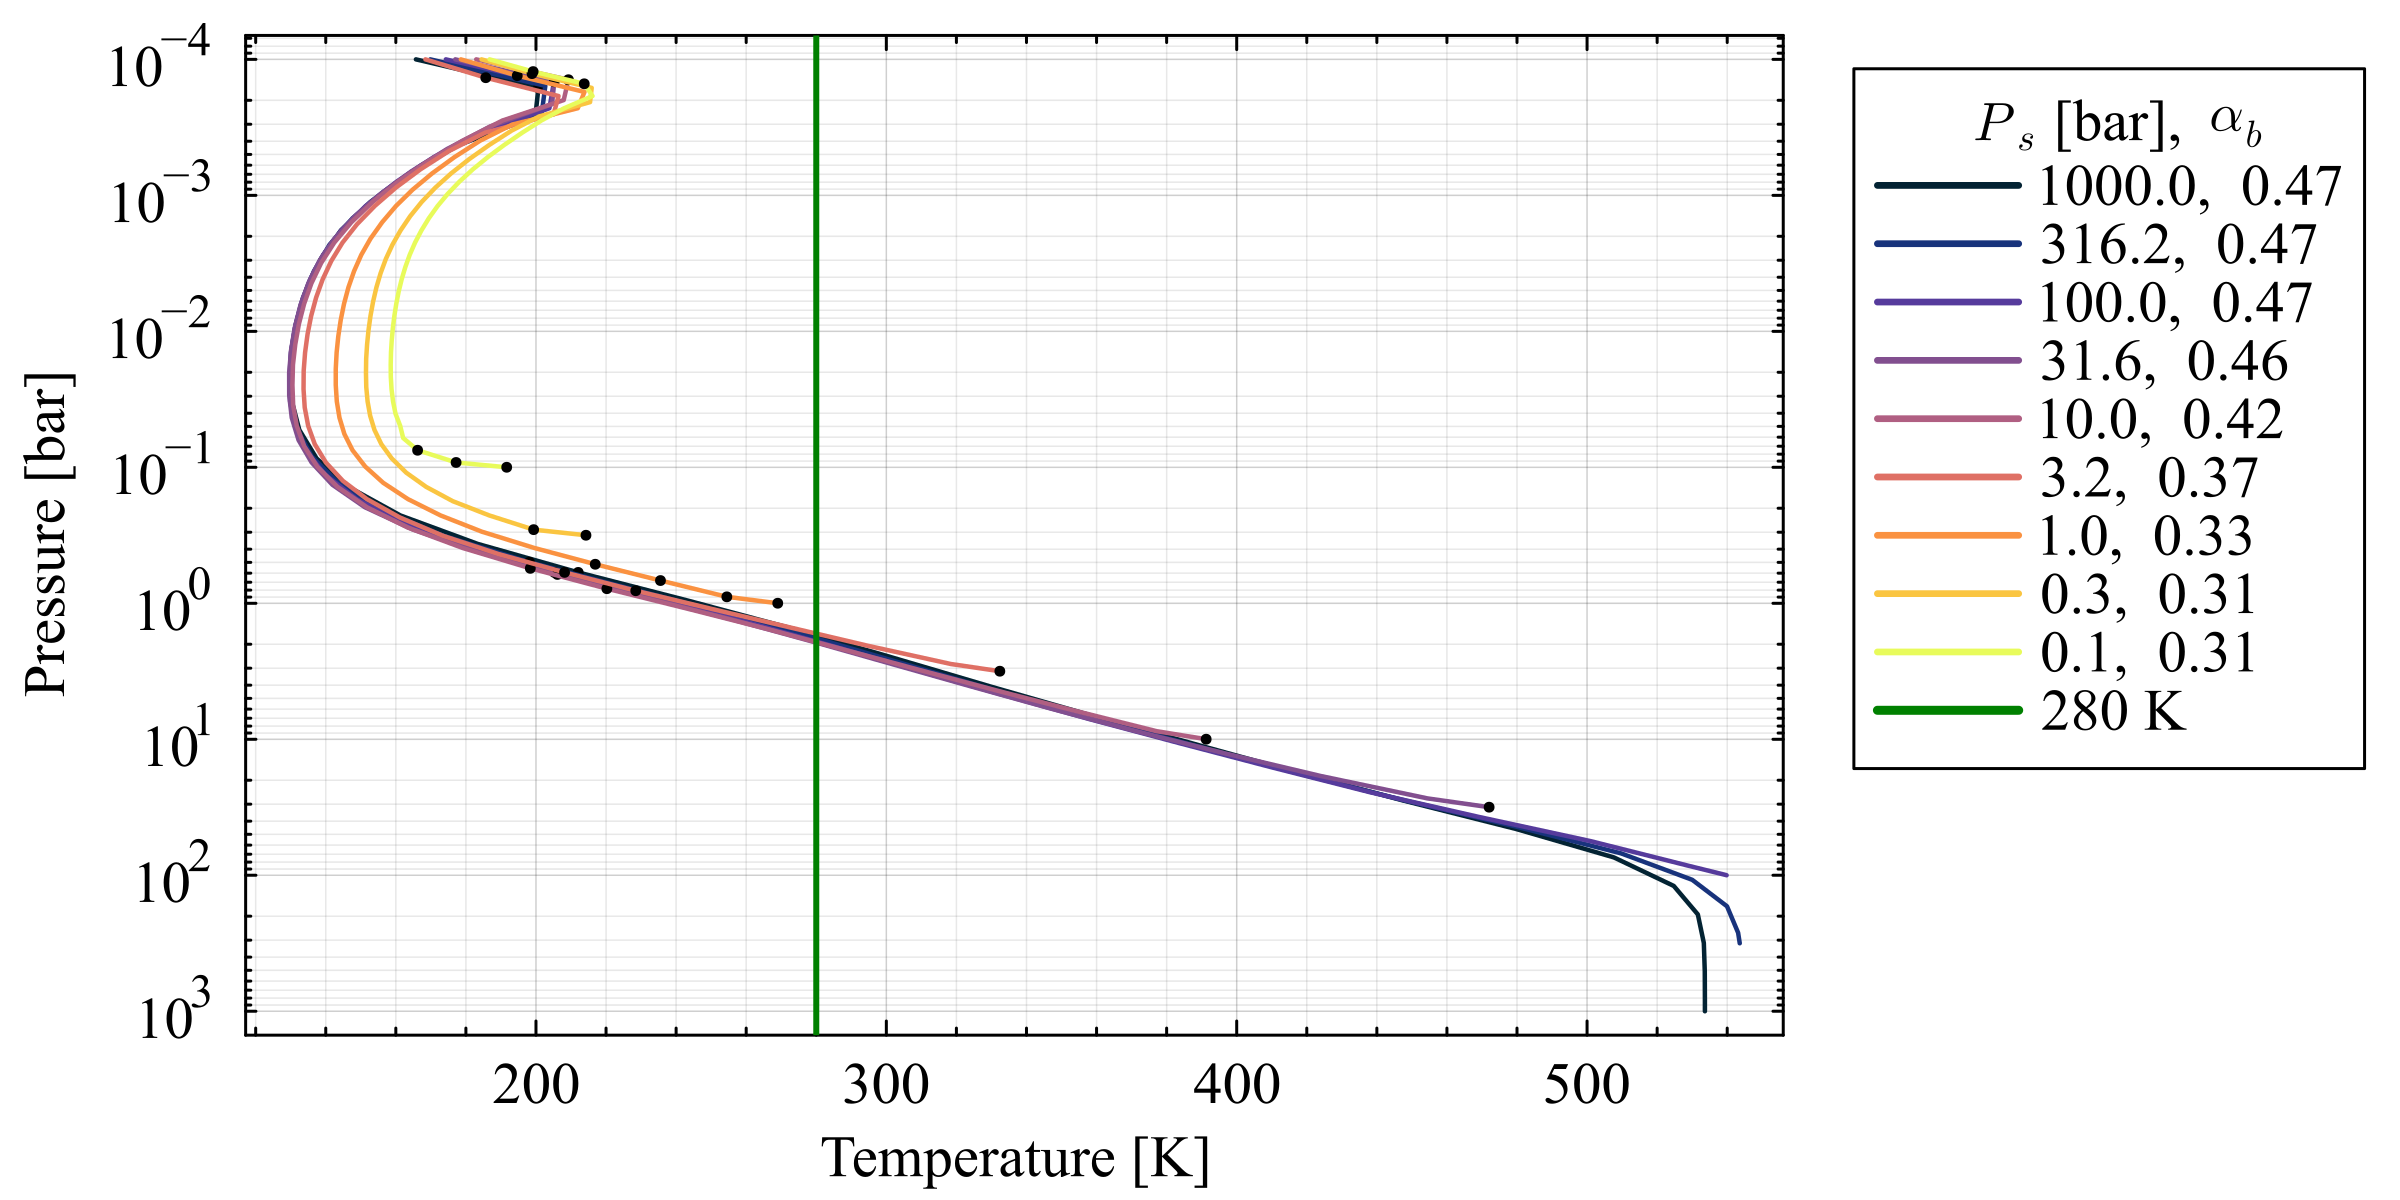

"/Users/nichollsh/Projects/AGNI/out/profiles.pdf"

In [16]:
ylims  = (p_top/1.5, 10.0^maximum(prs_arr)*1.5)
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(800,400), dpi=300, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, tickfontfamily=ff,
                guidefontsize=fs, guidefontfamily=ff,
                legendfontfamily=ff, legendfontsize=fs, 
                legendtitlefontfamily=ff, legendtitlefontsize=fs,
                leg_title=L"$P_s$ [bar],  $\alpha_b$",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)
          

p = Plots.palette(:thermal, nsamp)
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%.1f,  %.2f", 10.0^prs_arr[i], this_atm.flux_u_sw[1]/this_atm.flux_d_sw[1]))
    mask = falses(this_atm.nlev_l)
    mask[:] .= (this_atm.flux_cdry .> 0.0)
    scatter!(plt, this_atm.tmpl[mask], this_atm.pl[mask]*1e-5, markercolor="black", label="", markersize=2.0)
end 

vline!(plt, [280.0], lc="green", label="280 K", lw=2.0)

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

In [12]:
# for (i, atm) in enumerate(atm_arr)
#     dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
# end